In [1]:
from groundingdino.util.inference import load_model, load_image, predict, annotate
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

import cv2
import os
import torch
from torchvision.ops import box_convert
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [3]:
model = load_model("../third_party/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "../third_party/GroundingDINO/weights/groundingdino_swint_ogc.pth")

You are using a model of type clip to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


final text_encoder_type: bert-base-uncased


Some weights of BertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['encoder.layer.0.attention.self.key.weight', 'encoder.layer.5.output.LayerNorm.weight', 'encoder.layer.6.attention.self.value.weight', 'encoder.layer.1.attention.self.query.bias', 'encoder.layer.4.attention.self.key.bias', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.6.attention.self.key.bias', 'encoder.layer.11.attention.output.LayerNorm.bias', 'encoder.layer.7.attention.self.key.weight', 'encoder.layer.3.attention.output.LayerNorm.weight', 'encoder.layer.10.attention.output.dense.weight', 'encoder.layer.8.attention.output.dense.weight', 'encoder.layer.6.attention.output.dense.bias', 'encoder.layer.10.attention.self.query.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.3.intermediate.dense.bias', 'encoder.layer.3.output.dense.bias', 'encoder.layer.7.attention.self.value.weight', 'encoder.layer.10.attention.self.value.bias', 'encoder.

In [4]:
IMAGE_PATH = "images/5.png"
TEXT_PROMPT = "robot arm . jar . bottle cap."
BOX_TRESHOLD = 0.25
TEXT_TRESHOLD = 0.25

In [5]:
image_source, image = load_image(IMAGE_PATH)

In [ ]:
print(image)
boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

RuntimeError: stack expects a non-empty TensorList

In [157]:
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

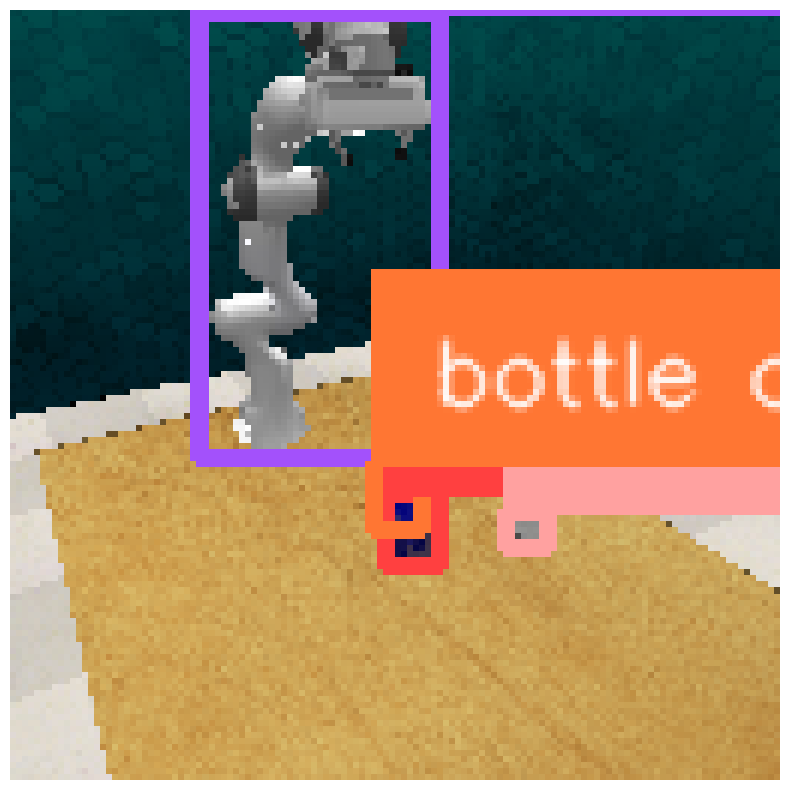

In [158]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [159]:
h, w, _ = image_source.shape
boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
boxes_xyxy = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()

In [160]:
sam2_checkpoint = "../sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device='cuda')

predictor = SAM2ImagePredictor(sam2_model)

In [161]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

In [162]:
image = Image.open(IMAGE_PATH)
image = np.array(image.convert("RGB"))
predictor.set_image(image)

In [163]:
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=boxes_xyxy,
    multimask_output=False,
)
print(len(masks))

4


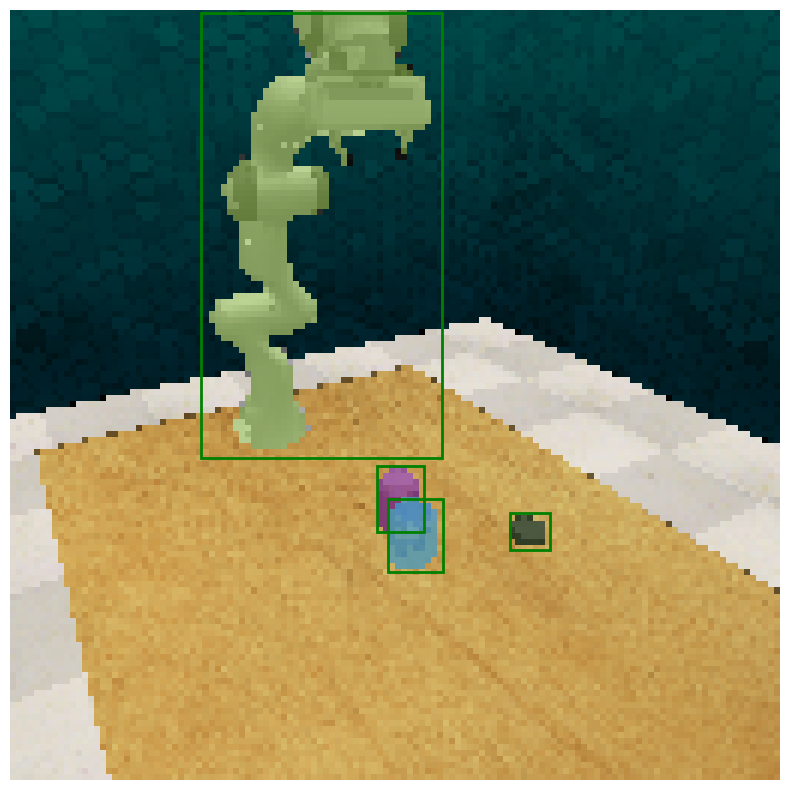

In [164]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in boxes_xyxy:
    show_box(box, plt.gca())
plt.axis('off')
plt.savefig("desk-segment.jpg")
plt.show()